# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Mean reversion testing and cointegration

</font>
</div>

# Imports
<hr style = "border:2px solid black" ></hr>

In [103]:
import pandas as pd
import statsmodels.tsa.stattools as ts
import pandas_datareader as pdr
import datetime as dt
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from matplotlib import rcParams

rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20

# Random-walk
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>
 
- The basic idea when trying to ascertain if a time series is mean-reverting is to use a statistical test to see if it differs from the behaviour of a random walk. 
- A **random walk** is a time series where the next directional movement is completely independent of any past movements - in essence the time series has no "memory" of where it has been. 
- A **mean-reverting** time series, however, is different. The change in the value of the time series in the next time period is proportional to the current value. Specifically, it is proportional to the difference between the mean historical price and the current price.

</font>
</div>

# Ornstein-Uhlenbeck series
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>
    
- Mathematically, such a (continuous) time series is referred to as an Ornstein-Uhlenbeck process. If we can show, statistically, that a price series behaves like an **Ornstein-Uhlenbeck series** then we can begin the process of forming a trading strategy around it. 
- Thus the goal of this chapter is to outline the statistical tests necessary to identify mean reversion and then use Python libraries (in particular statsmodels) in order to implement these tests. In particular, we will study the concept of stationarity and how to test for it.

</font>
</div>

 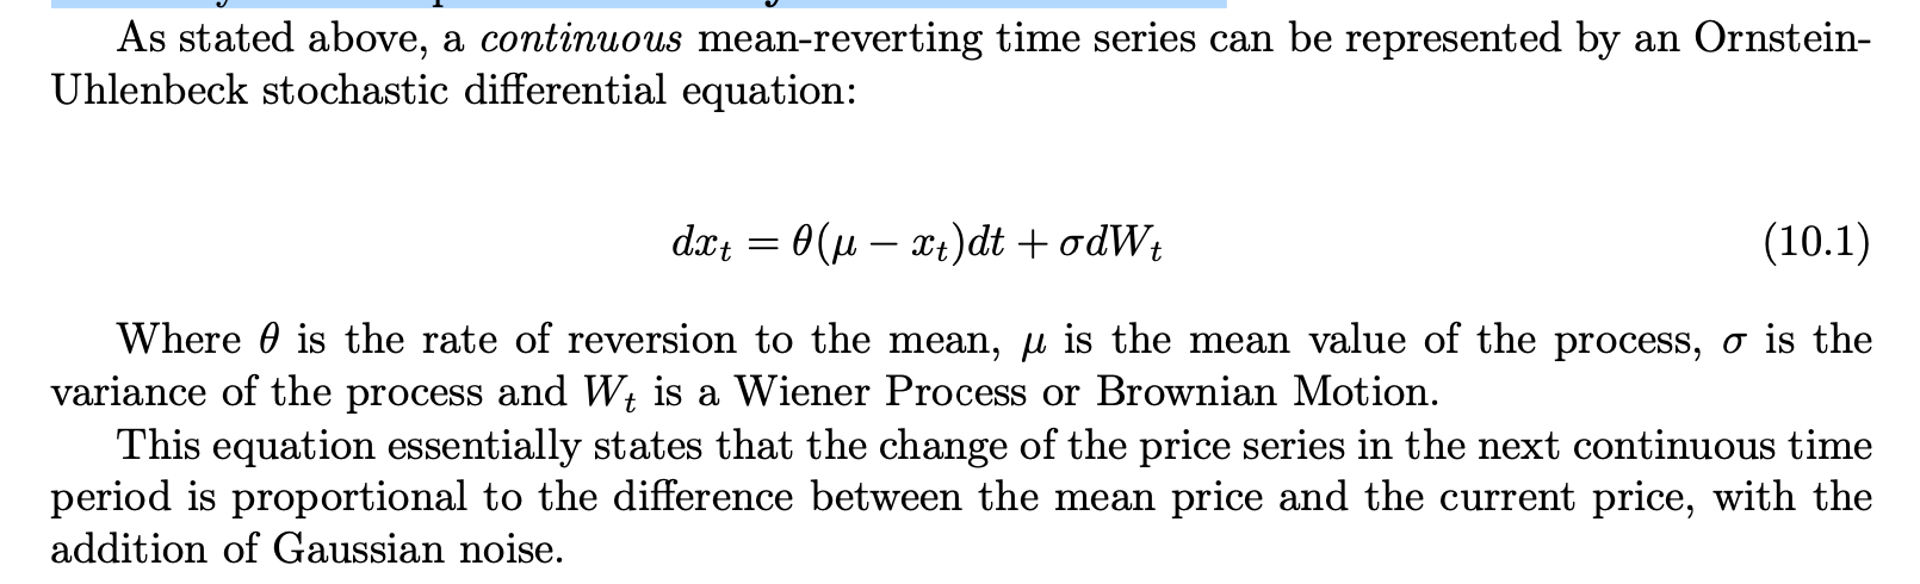

# Stationary timeseries
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- A time series (or stochastic process) is defined to be strongly stationary if its joint probability distribution is invariant under translations in time or space. In particular, and of key importance for traders, the mean and variance of the process do not change over time or space and they each do not follow a trend.
    
- A critical feature of stationary price series is that the prices within the series diffuse from their initial value at a rate slower than that of a GBM. 
    
- By measuring the rate of this diffusive behaviour we can identify the nature of the time series and thus detect whether it is mean-reverting.
    
- The **Hurst Exponent** helps us characterise the stationarity of a time series.

</font>
</div>

# Cointegration
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>
 
- It is difficult to find mean-reverting asset as equities broadly behave like GBMs and hence render the mean-reverting trade strategies relatively useless. 
- However, we can still create a portfolio of price series that is stationary so we can apply a mean-reverting trading strategies.
- The **pairs trade** does exactly this. Two companies in the same sector are likely to be exposed to similar market factors, which affect their businesses. Occasionally their relative stock prices will diverge due to certain events, but will revert to the long-running mean.

</font>
</div>

# Get the data
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>
 
- Let's consider two energy sector equities Exxon Mobil Corp given by the ticker XOM and United States Oil Fund given by the ticker USO.
    
- Both are exposed to similar market conditions and thus will likely have a stationary pairs relationship. 

</font>
</div>

In [74]:
# year-month-day format
start = dt.datetime(2019, 1, 1) 
end = dt.datetime(2020, 1, 1)

xom = pdr.get_data_yahoo("XOM", start, end) 
uso = pdr.get_data_yahoo("USO", start, end)


In [75]:
xom

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,69.870003,67.260002,67.349998,69.690002,16727200.0,56.254158
2019-01-03,70.250000,68.360001,70.000000,68.620003,13866100.0,55.390427
2019-01-04,71.269997,69.360001,69.639999,71.150002,16043600.0,57.432667
2019-01-07,72.099998,70.739998,71.250000,71.519997,10844200.0,57.731331
2019-01-08,72.589996,71.940002,72.540001,72.040001,11439000.0,58.151073
...,...,...,...,...,...,...
2019-12-24,70.500000,69.910004,70.349998,70.019997,3979400.0,59.227558
2019-12-26,70.500000,70.010002,70.190002,70.129997,8840200.0,59.320595
2019-12-27,70.309998,69.879997,70.199997,69.889999,10516100.0,59.117588


In [76]:
uso

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,80.639999,74.879997,75.360001,78.800003,4137850,78.800003
2019-01-03,80.080002,77.199997,79.919998,79.599998,4027375,79.599998
2019-01-04,83.120003,80.480003,81.360001,81.440002,4864513,81.440002
2019-01-07,84.160004,81.839996,82.160004,82.320000,4031138,82.320000
2019-01-08,84.400002,82.879997,83.440002,84.000000,3644150,84.000000
...,...,...,...,...,...,...
2019-12-24,102.320000,101.839996,101.839996,102.160004,431738,102.160004
2019-12-26,103.519997,102.559998,102.559998,103.120003,881688,103.120003
2019-12-27,103.680000,102.559998,103.360001,103.279999,1137988,103.279999


In [77]:
df = pd.DataFrame(index=xom.index)
df["XOM"] = xom["Adj Close"]
df["USO"] = uso["Adj Close"]

In [78]:
df

,XOM,USO
Date,,
2019-01-02,56.254158,78.800003
2019-01-03,55.390427,79.599998
2019-01-04,57.432667,81.440002
2019-01-07,57.731331,82.320000
2019-01-08,58.151073,84.000000
...,...,...
2019-12-24,59.227558,102.160004
2019-12-26,59.320595,103.120003
2019-12-27,59.117588,103.279999


# EDA
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>
 
- By creating a scatter plot of their prices, we'll see the relationship is broadly linear.

</font>
</div>

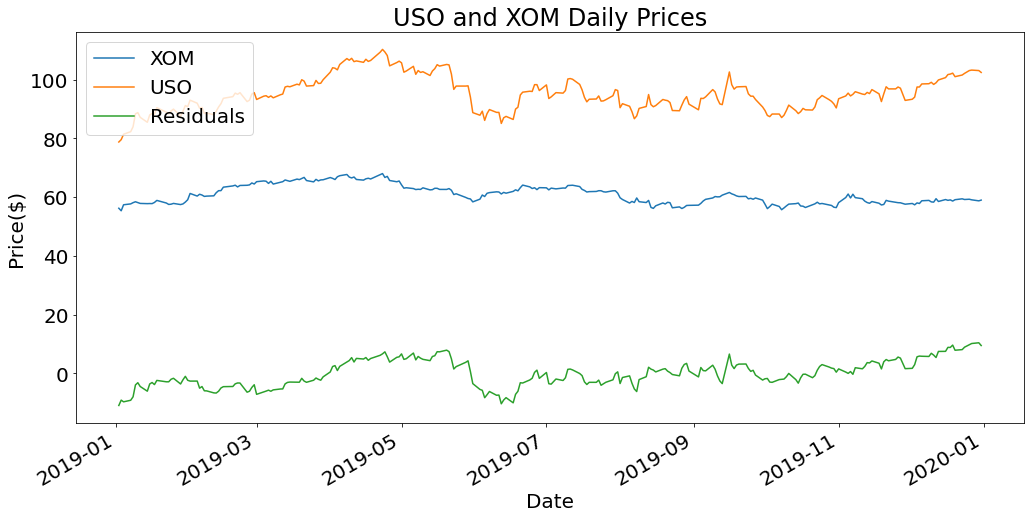

In [83]:
fig = df.plot(title="USO and XOM Daily Prices")
fig.set_ylabel("Price($)")
plt.show()

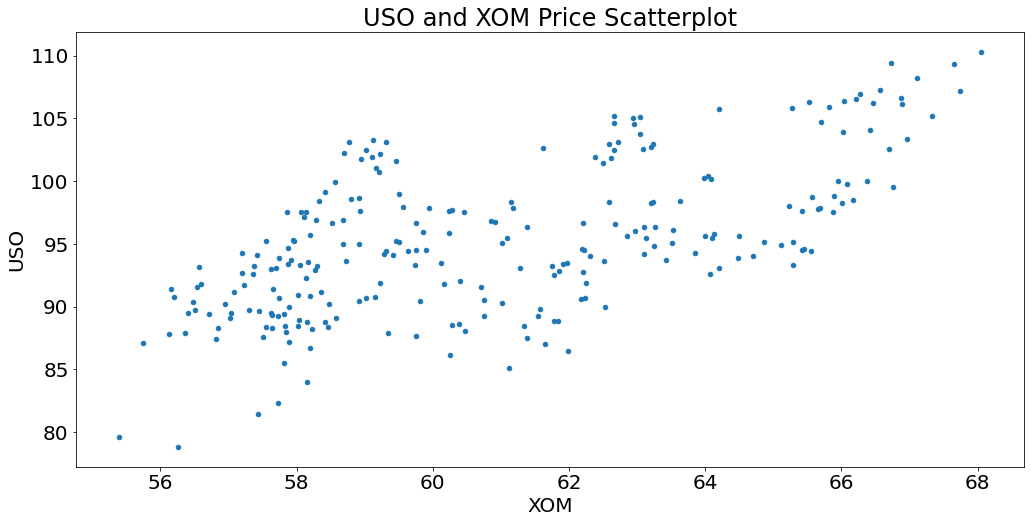

In [84]:
df.plot.scatter(x=0, y=1, title="USO and XOM Price Scatterplot")
plt.show()

# Create residual
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>
 
- The pairs trade essentially works by using a linear model for a relationship between the two stock prices.
- While plotting the residual is does not seem particularly stationary.
    
</font>
</div>

In [87]:

# Create OLS model
Y = df['USO']
x = df['XOM']
x = sm.add_constant(x)
model = sm.OLS(Y, x)
res = model.fit()

# Beta hedge ratio (coefficent from OLS)
beta_hr = res.params[1]
print(f'Beta Hedge Ratio: {beta_hr}')

# Residuals
df["Residuals"] = res.resid

Beta Hedge Ratio: 1.1819284664568919


In [95]:
df

,XOM,USO,Residuals
Date,,,
2019-01-02,56.254158,78.800003,-10.886452
2019-01-03,55.390427,79.599998,-9.065588
2019-01-04,57.432667,81.440002,-9.639366
2019-01-07,57.731331,82.320000,-9.112368
2019-01-08,58.151073,84.000000,-7.928473
...,...,...,...
2019-12-24,59.227558,102.160004,8.959202
2019-12-26,59.320595,103.120003,9.809239
2019-12-27,59.117588,103.279999,10.209174


In [100]:
df.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)

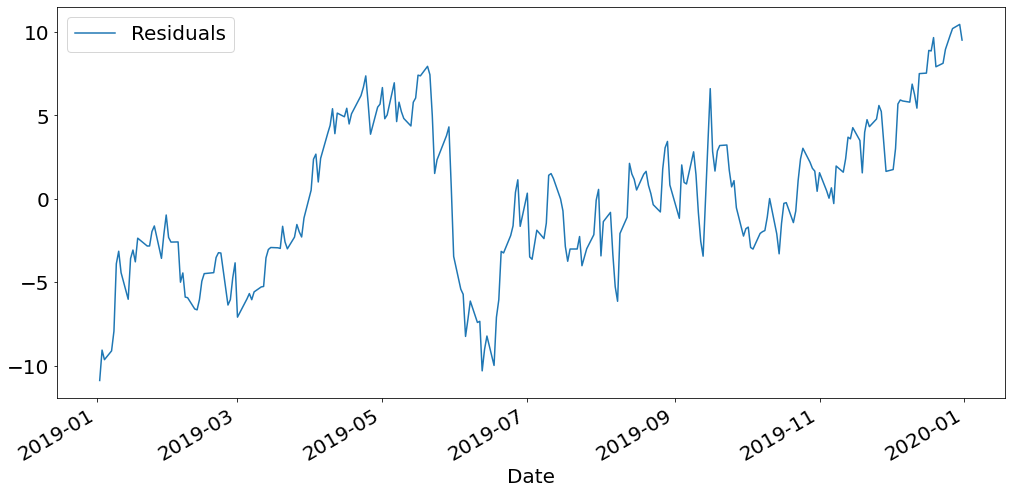

In [110]:
df.plot(y="Residuals")
fig.set_ylabel("Price($)")
plt.show()

# Cointegrated Augmented Dickey-Fuller (CADF)
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- The Cointegrated Augmented Dickey-Fuller (CADF) determines the optimal hedge ratio by performing a linear regression against the two time series and then tests for stationarity under the linear combination.
- It can be seen that the calculated test statistic of -2.891 is more negative than the 5% critical value of -2.873, which means that we can reject the null hypothesis that there isn't a cointegrating relationship at the 5% level. 
- Hence we can conclude, with a reasonable degree of certainty, that USO and XOM possess a cointegrating relationship, at least for the time period sample considered.

</font>
</div>

In [112]:
ts.adfuller(df["Residuals"])

(-2.891341771226023,
 0.04636413541245603,
 0,
 251,
 {'1%': -3.4566744514553016,
  '5%': -2.8731248767783426,
  '10%': -2.5729436702592023},
 878.8436373842353)

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing/
- https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing-Part-II/
    
</font>
</div>